## Zebrafish data alignment and visualization

### Imports

In [1]:
# Needed packages
import numpy as np
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy import ndimage
from skimage import io
import cv2
from skimage.color import rgb2gray
import plotly.graph_objects as go
import plotly.io as pio
import pickle
from scipy.ndimage import zoom
from scipy.interpolate import RegularGridInterpolator
from numba import njit
from multiprocessing import Pool
import copy
import itk
import logging
from umap import UMAP
from sklearn.cluster import KMeans
import plotly.express as px
import subprocess

# For working display in vscode
pio.renderers.default = "notebook_connected"


### Process reference

In [2]:
# Load reference
array_reference = np.array(io.imread("reference/48hrs.tif"), dtype=np.int32)

# Correct orientation
array_reference = np.transpose(array_reference, axes=[1, 0, 2])

# Correct axes indices
array_reference = np.moveaxis(array_reference, 2, 0)

# Decrease resolution for faster processing
subsampling_x = 3
subsampling_yz = 3
array_reference = array_reference[::subsampling_x, ::subsampling_yz, ::subsampling_yz]

# Crop beginning/end and top/bottom as it's empty
array_reference = array_reference[50:180, 60:-35, :]


# Decrease size reference and repad
zoom_parameter = 0.7
size_reference = np.array(array_reference.shape)
array_reference = zoom(array_reference, (1,zoom_parameter,zoom_parameter))
padding_top = abs(int(np.ceil((array_reference.shape[1]-size_reference[1])/2)))
padding_bottom = abs(int(np.floor((array_reference.shape[1]-size_reference[1])/2)))
padding_left = abs(int(np.ceil((array_reference.shape[2]-size_reference[2])/2)))
padding_right = abs(int(np.floor((array_reference.shape[2]-size_reference[2])/2)))
array_reference = np.pad(array_reference, pad_width = [(0,0),(padding_top,padding_bottom),(padding_left,padding_right)])

In [3]:
# Build function to tilt the reference vertically and horizontally
def tilt_array(array, angle_x, angle_y, angle_z):
    temp = ndimage.rotate(array, angle=angle_x, axes=(1, 2), order=1, reshape=False)
    temp = ndimage.rotate(temp, angle=angle_y, axes=(0, 2), order=1, reshape=False)
    array_reference_tilted = ndimage.rotate(
        temp, angle=angle_z, axes=(0, 1), order=1, reshape=False
    )
    return array_reference_tilted


# Make a test with some arbitraty angles
angle_x = 10
angle_y = 10
angle_z = 10

array_tilted = tilt_array(array_reference, angle_x, angle_y, angle_z)

# Shape is not changed by the tilt
print(array_tilted[0].shape)



(199, 475)


In [4]:
# Widget slider to browse the data
size = widgets.IntSlider(
    value=5, min=0, max=array_reference.shape[0] - 1, step=1, description="Slice"
)

# Widget interaction function
def anim(size):
    plt.imshow(array_tilted[size, :, :], vmin=0, vmax=255)
    return

# Link widget and function
out = widgets.interactive_output(anim, {"size": size})

# Display result
display(size, out)


IntSlider(value=5, description='Slice', max=129)

Output()

### Process MALDI data

In [5]:
# Build a dictionnary of images for the raw data (for each mz value)
# The data is normalized across slices between 0 and 1
dic_lipid_arrays = {}
for lipid in sorted(os.listdir("data/arrays")):
    path = "data/arrays/" + lipid + '/'
    try:
        l_str_indices = [x for x in os.listdir(path) if "npy" in x]
        l_slice_index = [int(x.split(".npy")[0]) for x in l_str_indices]
        sorted_l_slice_index, sorted_l_path = zip(*sorted(zip(l_slice_index, l_str_indices)))
        dic_lipid_arrays[lipid] = [np.load(path+x) for x in sorted_l_path]
    except Exception as e:
        print("The following directory couldn't be processed. Reason: ", e)
    

The following directory couldn't be processed. Reason:  [Errno 20] Not a directory: 'data/arrays/Icon\r/'


In [6]:
# Build a list of images representing different lipid expressions
l_lipids_channel_1 = ['460.289632', '469.185955']
l_lipids_channel_2 = ['481.146834',] 
l_lipids_channel_3 = 'all'

ll_array_slice = []
for l_lipids in [l_lipids_channel_1, l_lipids_channel_2, l_lipids_channel_3]:
    l_array_slice_channel = []
    if l_lipids == 'all':
        l_lipids = list(dic_lipid_arrays.keys())
    for lipid in l_lipids:
            l_images = dic_lipid_arrays[lipid]
            if len(l_array_slice_channel) > 0:
                for i, image in enumerate(l_images):
                    l_array_slice_channel[i]+=image
            else:
                for i, image in enumerate(l_images):
                    l_array_slice_channel.append(image)

    # Renormalize this list if TIC
    if l_lipids == 'all':
        for i, image in enumerate(l_array_slice_channel):
            l_array_slice_channel[i] = image/np.percentile(image, 99.9)
            l_array_slice_channel[i] = np.clip(l_array_slice_channel[i], 0, 1)

    # Add to the list of channels
    ll_array_slice.append(l_array_slice_channel)

# Merge all list in images with 3 channel
n_slices = len(ll_array_slice[0])
list_slice_idx = list(range(n_slices))
l_array_slice = []
for idx_slice in list_slice_idx:
    l_array_slice.append(np.stack((ll_array_slice[0][idx_slice], ll_array_slice[1][idx_slice], ll_array_slice[2][idx_slice]), axis = -1))



In [7]:
size = widgets.IntSlider(value=5, min=0, max=len(l_array_slice) - 1, step=1, description="Slice")
def anim(size):
    plt.imshow(l_array_slice[size][:, :,1], vmin=0)#, vmax=1)
    return
out = widgets.interactive_output(anim, {"size": size})
display(size, out)

IntSlider(value=5, description='Slice', max=19)

Output()

In [8]:
# Pad all images to the same size
# This way I can store them all in a numpy array
def pad_images_to_same_size(images):

    # Set initial variables for width and height
    width_max = 0
    height_max = 0

    # Browse images and update width_max and height_max if needed
    for img in images:
        h, w = img.shape[:2]
        width_max = max(width_max, w)
        height_max = max(height_max, h)

    # Pad each image by adding (empty) missing pixels w.r.t. width_max and height_max
    # Padding is distributed equally both vertically and horizontally
    images_padded = []
    for img in images:
        h, w = img.shape[:2]
        diff_vert = height_max - h
        pad_top = diff_vert // 2
        pad_bottom = diff_vert - pad_top
        diff_hori = width_max - w
        pad_left = diff_hori // 2
        pad_right = diff_hori - pad_left
        img_padded = cv2.copyMakeBorder(
            img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0
        )
        assert img_padded.shape[:2] == (height_max, width_max)
        images_padded.append(img_padded)

    # Return padded images
    return np.array(images_padded)

# Pad the array used for alignment
array_slice = pad_images_to_same_size(l_array_slice)
print(array_slice.shape)

# Same with the set of all lipid images
for key, l_array_slice_lipid in dic_lipid_arrays.items():
    dic_lipid_arrays[key] = pad_images_to_same_size(l_array_slice_lipid)


(20, 150, 414, 3)


In [9]:
# Reference appears to be slightly bigger than MALDI data, 
# Pad all MADI data to the same size as reference for easier comparison
# Alternate between floor and ceil in case padding is an odd number
padding_top = int(np.ceil((array_reference.shape[1]-array_slice.shape[1])/2))
padding_bottom = int(np.floor((array_reference.shape[1]-array_slice.shape[1])/2))
padding_left = int(np.ceil((array_reference.shape[2]-array_slice.shape[2])/2))
padding_right = int(np.floor((array_reference.shape[2]-array_slice.shape[2])/2))

# Pad the array used for alignment
array_slice = np.pad(array_slice, pad_width = [(0,0),(padding_top,padding_bottom),(padding_left,padding_right),(0,0)])
print(array_slice.shape)

# Same with the set of all lipid images
for key, array_slice_lipid in dic_lipid_arrays.items():
    dic_lipid_arrays[key] = np.pad(array_slice_lipid, pad_width = [(0,0),(padding_top,padding_bottom),(padding_left,padding_right),])


(20, 199, 475, 3)


In [10]:
# Widget slider to browse the data
size = widgets.IntSlider(value=0, min=0, max=array_slice.shape[0]*11 - 1, step=1, description="Slice")


# dropdown to display invidual lipids
l_lipids = list(dic_lipid_arrays.keys())
lipid_dropdown = widgets.Dropdown(
    value=l_lipids[0],
    options=l_lipids + ['alignment data'],
    description="Lipid to display:",
)
ui = widgets.HBox([size, lipid_dropdown])

# Widget interaction function
def anim(size, lipid):
    if lipid == 'alignment data':
        plt.imshow(array_slice[size][:, :, 0], vmin=0, vmax=1)
    else:
        plt.imshow(dic_lipid_arrays[lipid_dropdown.value][size], vmin=0)#, vmax=1)
    return

# Link widget and function
out = widgets.interactive_output(anim, {"size": size, 'lipid': lipid_dropdown})

# Display result
display(ui, out)




Output()

### Build functions for alignment

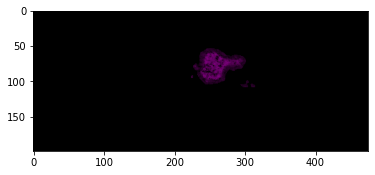

In [11]:
# Function to translate data left or right
def translate(image, x = 0, y = 0):
    # Translate horizontally
    image = np.concatenate((image[:,-x:],image[:,:-x]), axis = 1)
    # Translate vertically
    image = np.concatenate((image[y:,:], image[:y,:]), axis = 0)
    # Return result
    return image

image = array_slice[0]

plt.imshow(translate(image, x = 50, y = 20), vmin=0, vmax=1)
plt.show()

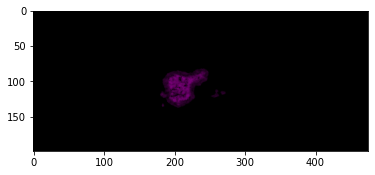

In [12]:
# Function to rotate image
def rotate(image, angle=0):
    # Rotate image and return
    return ndimage.rotate(image, angle=angle, axes=(1, 0), order=1, reshape=False)


image = array_slice[0]
plt.imshow(rotate(image, angle=20), vmin=0, vmax=1)
plt.show()


In [13]:
# Build a complex widget to do the slice positioning manually
def plot(
    angle_x,
    angle_y,
    angle_z,
    shift,
    c,
    reverse_reference,
    superimpose,
    individual_slice_index,
    individual_shift_value,
    individual_translation_x_value,
    individual_translation_y_value,
    individual_rotation_value,
):
    # Update dic of shifts with the shift of the current slice
    individual_slice_index = int(individual_slice_index.split(" ")[-1]) - 1
    global previous_slice_index
    global individual_shift
    global individual_translation_x
    global individual_translation_y
    global individual_rotation
    if individual_slice_index == previous_slice_index:
        dic_individual_shifts[individual_slice_index] = individual_shift_value
        dic_individual_translation_x[individual_slice_index] = individual_translation_x_value
        dic_individual_translation_y[individual_slice_index] = individual_translation_y_value
        dic_individual_rotation[individual_slice_index] = individual_rotation_value
    else:
        individual_shift_value = dic_individual_shifts[individual_slice_index]
        individual_translation_x_value = dic_individual_translation_x[individual_slice_index]
        individual_translation_y_value = dic_individual_translation_y[individual_slice_index]
        individual_rotation_value = dic_individual_rotation[individual_slice_index]
        previous_slice_index = individual_slice_index

        # Update slider values
        individual_shift.value = individual_shift_value
        individual_translation_x.value = individual_translation_x_value
        individual_translation_y.value = individual_translation_y_value
        individual_rotation.value = individual_rotation_value

    # Build a grid with 4 columns (2 for data, 2 for reference)
    len_col = int(np.ceil(array_slice.shape[0] / 2))
    fig, arr_ax = plt.subplots(len_col, 4, figsize=(18, 20), constrained_layout=True)

    # Channels activation/deactivation
    if c == "All channels":
        l_c = [0, 1, 2]
    elif c == "Channel 1":
        l_c = [0]
    elif c == "Channel 2":
        l_c = [1]
    elif c == "Channel 3":
        l_c = [2]

    # Plot the data
    for idx, slice in enumerate(array_slice):
        arr_ax[idx % len_col, 2 * (idx // len_col)].imshow(
            rotate(
                translate(
                    slice[:, :, l_c],
                    dic_individual_translation_x[idx],
                    dic_individual_translation_y[idx],
                ),
                angle=dic_individual_rotation[idx],
            ),
        )
        # arr_ax[idx % len_col, 2 * (idx // len_col)].set_title("S" + str(idx + 1))
        arr_ax[idx % len_col, 2 * (idx // len_col)].set_title(
            "S" + str(idx + 1), y=1.0, pad=-14, color="orange"
        )

    # Compute tilted reference
    array_tilted = tilt_array(array_reference, angle_x, angle_y, angle_z)

    # Reverse reference order if needed
    if reverse_reference:
        array_tilted = array_tilted[::-1]

    # Plot the reference
    for idx, idx_slice in enumerate(list_slice_idx):
        arr_ax[idx % len_col, 1 + 2 * (idx // len_col)].imshow(
            array_tilted[idx_slice + shift + dic_individual_shifts[idx], :, :], vmin=0, vmax=255,
        )
        arr_ax[idx % len_col, 1 + 2 * (idx // len_col)].set_title(
            "z=" + str(idx_slice + shift + dic_individual_shifts[idx]),
            y=1.0,
            pad=-14,
            color="orange",
        )

        if superimpose:
            masked_data = np.ma.masked_where(array_tilted < 2, array_tilted)

            arr_ax[idx % len_col, 2 * (idx // len_col)].imshow(
                masked_data[idx_slice + shift + dic_individual_shifts[idx], :, :],
                vmin=0,
                vmax=255,
                cmap="viridis_r",
                alpha=0.5,
            )

    # Hide x labels and tick labels
    for ax in arr_ax.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    # Empty return, as this function is only used for plotting
    return


# Build the sliders used for changing angle, overall shift, channels used
slider_angle_x = widgets.IntSlider(
    value=0, min=-50, max=50, step=1, continuous_update=False, description="x angle"
)
slider_angle_y = widgets.IntSlider(
    value=0, min=-50, max=50, step=1, continuous_update=False, description="y angle"
)
slider_angle_z = widgets.IntSlider(
    value=0, min=-50, max=50, step=1, continuous_update=False, description="z angle"
)
slider_shift = widgets.IntSlider(
    value=50, min=-200, max=200, step=1, continuous_update=False, description="Overall shift"
)
channels = widgets.Dropdown(
    value="Channel 3",
    options=["All channels", "Channel 1", "Channel 2", "Channel 3"],
    description="Channels",
)

# Add possibility to resverse order of the reference, and superimpose data and reference
reverse_reference = widgets.Checkbox(description="Reverse reference", value=True)
superimpose = widgets.Checkbox(description="Superimpose reference", value=False)

# Layout for widgets with long description
style = {"description_width": "initial"}


# Widgets for individual slices
individual_slices = widgets.Dropdown(
    value="Slice 1",
    options=["Slice " + str(x + 1) for x in range(array_slice.shape[0])],
    description="Modify individual slices",
    style=style,
)
# Dictionnary to store all shifts
dic_individual_shifts = {x: 0 for x in range(array_slice.shape[0])}
dic_individual_translation_x = {x: 0 for x in range(array_slice.shape[0])}
dic_individual_translation_y = {x: 0 for x in range(array_slice.shape[0])}
dic_individual_rotation = {x: 0 for x in range(array_slice.shape[0])}

# Build the widgets for individual shifts
individual_shift = widgets.IntSlider(
    value=0,
    min=-100,
    max=100,
    step=1,
    continuous_update=False,
    description="Individual shift",
    style=style,
)

individual_translation_x = widgets.IntSlider(
    value=0,
    min=-200,
    max=200,
    step=1,
    continuous_update=False,
    description="Individual translation x",
    style=style,
)

individual_translation_y = widgets.IntSlider(
    value=0,
    min=-100,
    max=100,
    step=1,
    continuous_update=False,
    description="Individual translation y",
    style=style,
)

individual_rotation = widgets.IntSlider(
    value=0,
    min=-200,
    max=200,
    step=1,
    continuous_update=False,
    description="Individual rotation angle",
    style=style,
)

# Organize widgets in 4 rows
general_controls = widgets.HBox([slider_shift, slider_angle_x, slider_angle_y, slider_angle_z])
individual_shifts = widgets.HBox(
    [
        individual_slices,
        individual_shift,
        individual_translation_x,
        individual_translation_y,
    ]
)
other_controls = widgets.HBox([individual_rotation, reverse_reference, superimpose, channels])

# Align 4 rows vertically
controls = widgets.VBox([general_controls, individual_shifts, other_controls])

# Keep track of slice index to update widgets properly
previous_slice_index = 0


In [14]:
print(individual_translation_x)

IntSlider(value=0, continuous_update=False, description='Individual translation x', max=200, min=-200, style=SliderStyle(description_width='initial'))


In [15]:
# Load parameters from save
load_from_save = True
if load_from_save:
    with open("save/parameters.pickle", "rb") as handle:
        [
            slider_angle_x.value,
            slider_angle_y.value,
            slider_angle_z.value,
            reverse_reference.value,
            slider_shift.value,
            dic_individual_shifts,
            channels.value,
            dic_individual_translation_x,
            dic_individual_translation_y,
            dic_individual_rotation,
        ] = pickle.load(handle)
    individual_translation_x.value = dic_individual_translation_x[0]
    individual_translation_y.value = dic_individual_translation_y[0]
    individual_rotation.value = dic_individual_rotation[0]

# Connect widgets and plotting function
out = widgets.interactive_output(
    plot,
    {
        "angle_x": slider_angle_x,
        "angle_y": slider_angle_y,
        "angle_z": slider_angle_z,
        "shift": slider_shift,
        "c": channels,
        "reverse_reference": reverse_reference,
        "superimpose": superimpose,
        "individual_slice_index": individual_slices,
        "individual_shift_value": individual_shift,
        "individual_translation_x_value": individual_translation_x,
        "individual_translation_y_value": individual_translation_y,
        "individual_rotation_value": individual_rotation,
    },
)


# Display final result
display(controls, out)


Output()

In [16]:
# Cell to save parameters of the manual alignment
with open("save/parameters.pickle", "wb") as handle:
    pickle.dump(
        [
            slider_angle_x.value,
            slider_angle_y.value,
            slider_angle_z.value,
            reverse_reference.value,
            slider_shift.value,
            dic_individual_shifts,
            channels.value,
            dic_individual_translation_x,
            dic_individual_translation_y,
            dic_individual_rotation,
        ],
        handle,
    )


### Apply the alignment to the MALDI data and reference

In [17]:
# Get the reference data for warping later on
array_tilted = tilt_array(array_reference, slider_angle_x.value, slider_angle_y.value, slider_angle_z.value)

# Turn to float format between 0 and 1
array_tilted = array_tilted / 255

# Reverse if needed
if reverse_reference.value:
    array_tilted = array_tilted[::-1]

# Load the reference images with the proper indices used for warping
array_images_reference = np.array(
    [
        array_tilted[idx_slice + slider_shift.value + dic_individual_shifts[idx], :, :]
        for idx, idx_slice in enumerate(list_slice_idx)
    ]
)

# Get channel value
c = channels.value
if c == "All channels":
    l_c = [0, 1, 2]
elif c == "Channel 1":
    l_c = [0]
elif c == "Channel 2":
    l_c = [1]
elif c == "Channel 3":
    l_c = [2]

# Then load the data with proper positioning
array_images_data = np.array(
    [
        rotate(
            translate(
                slice[:, :, l_c],
                dic_individual_translation_x[idx],
                dic_individual_translation_y[idx],
            ),
            angle=dic_individual_rotation[idx],
        )
        for idx, slice in enumerate(array_slice)
    ]
)

# Also convert the dictionnary containing all lipids images
for key, array_slice_lipid in dic_lipid_arrays.items():
    dic_lipid_arrays[key] = np.array(
    [
        rotate(
            translate(
                slice,
                dic_individual_translation_x[idx],
                dic_individual_translation_y[idx],
            ),
            angle=dic_individual_rotation[idx],
        )
        for idx, slice in enumerate(dic_lipid_arrays[key])
    ]
)

### Do an automated registration to improve the alignment

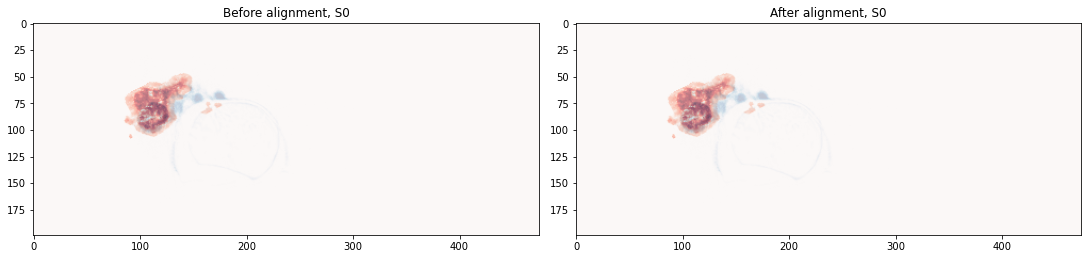

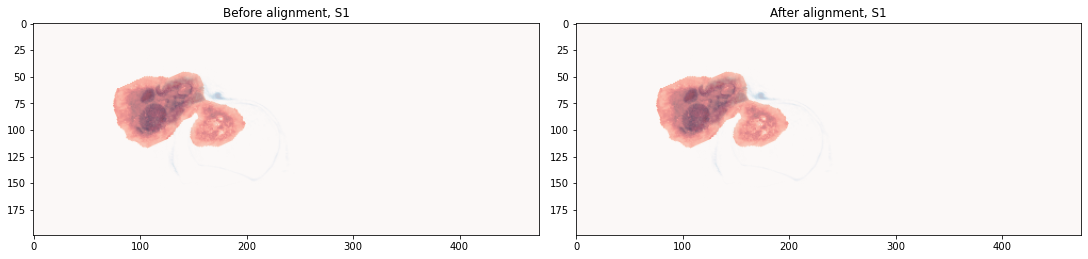

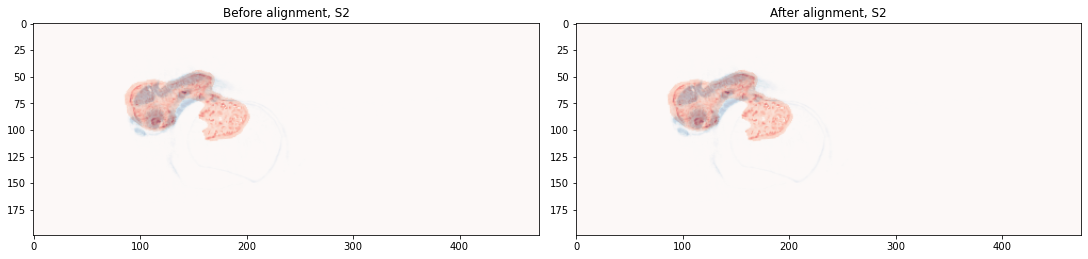

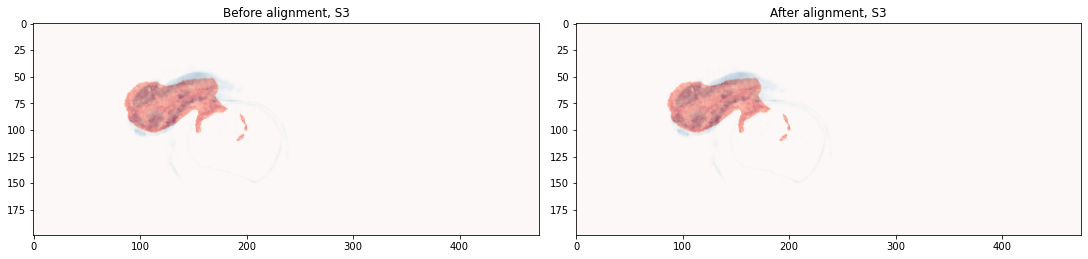

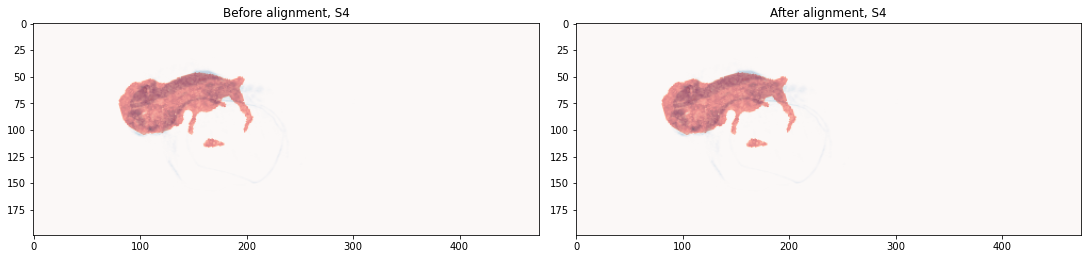

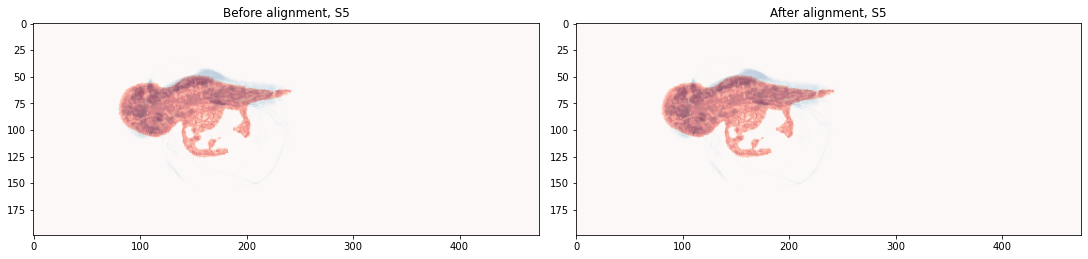

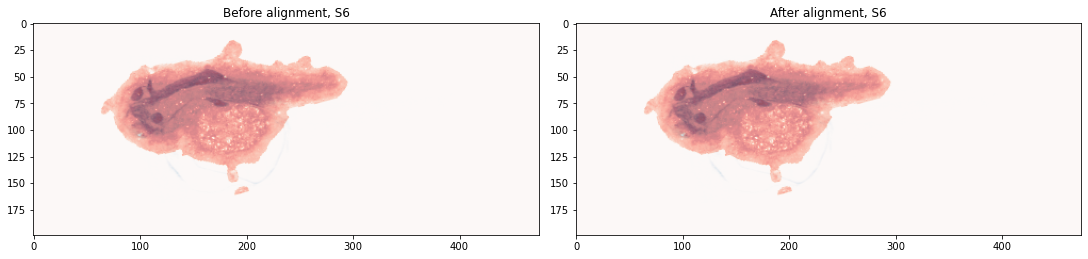

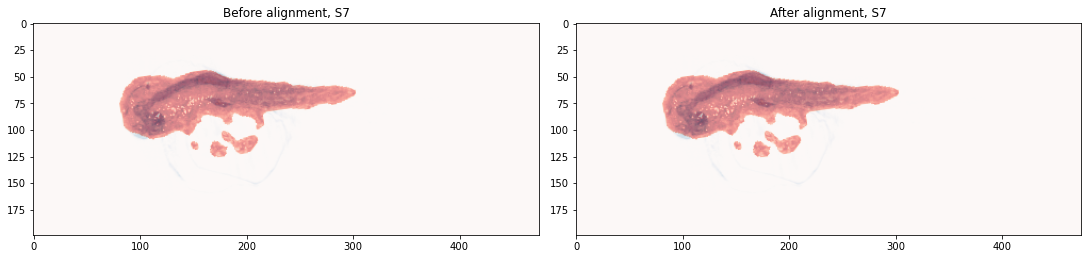

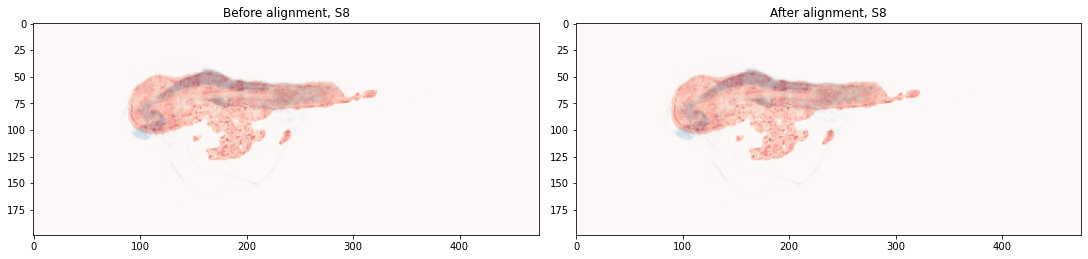

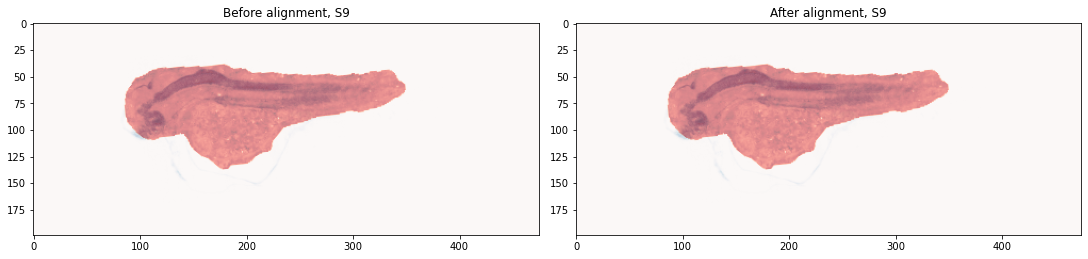

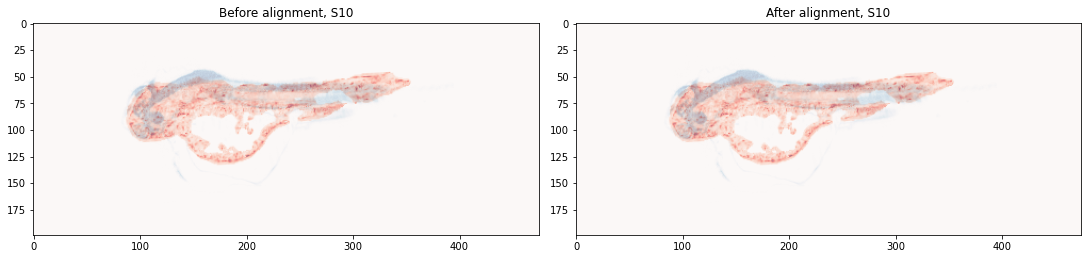

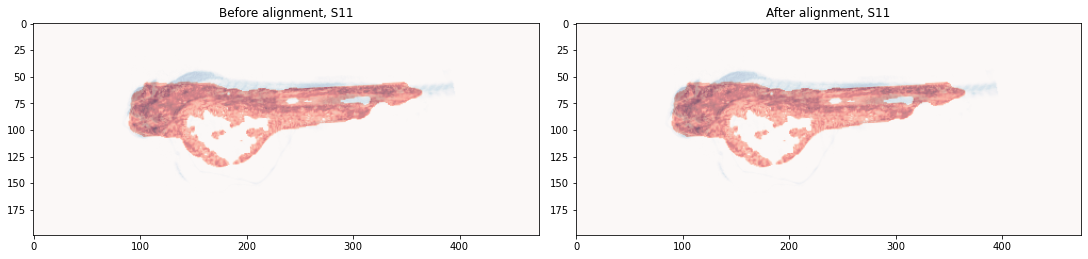

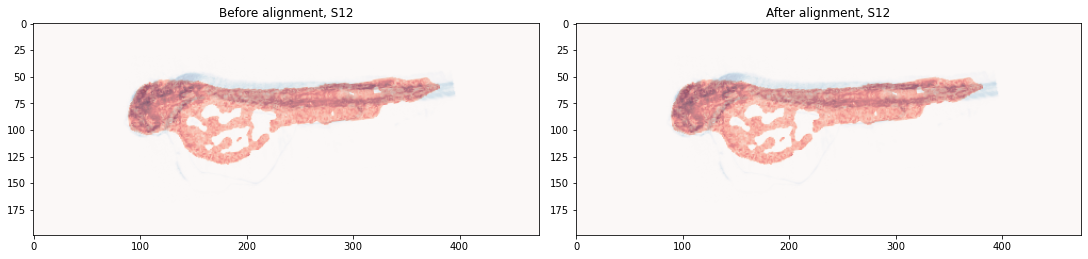

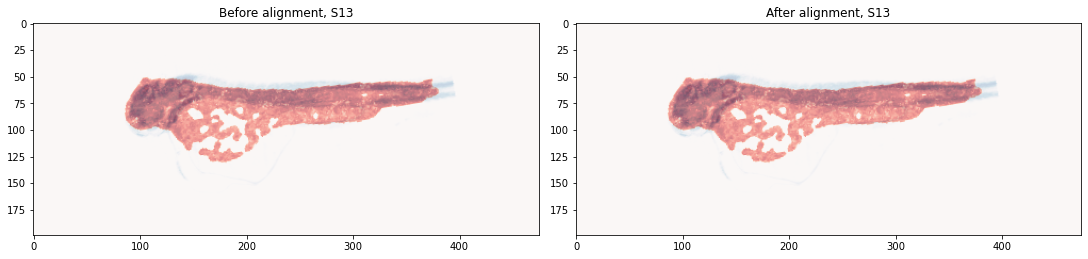

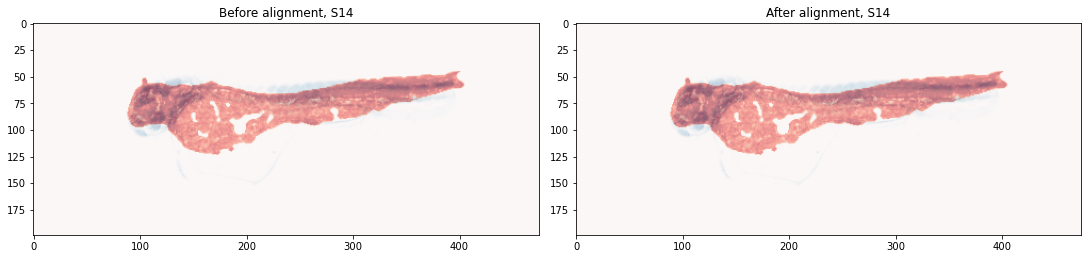

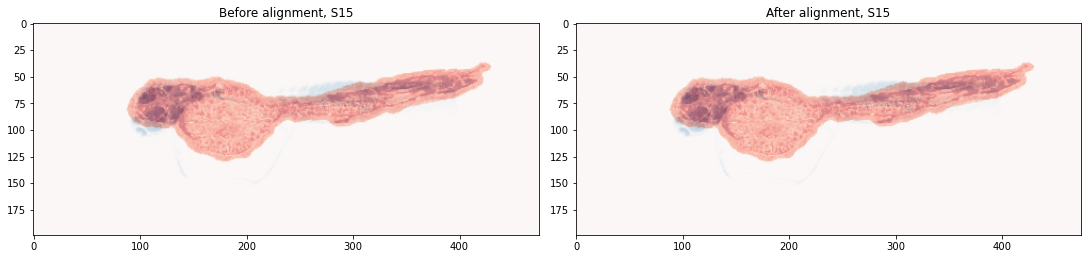

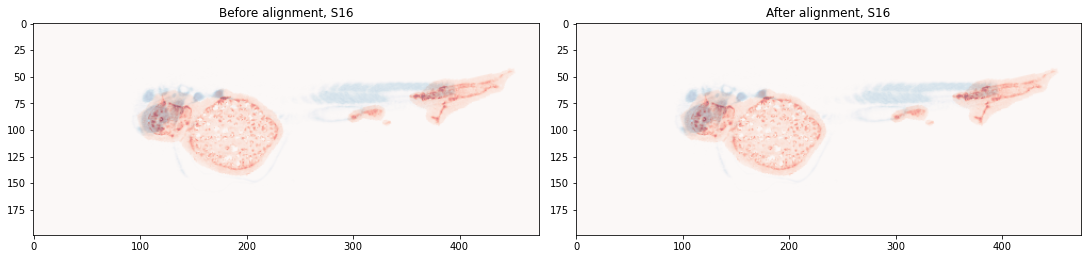

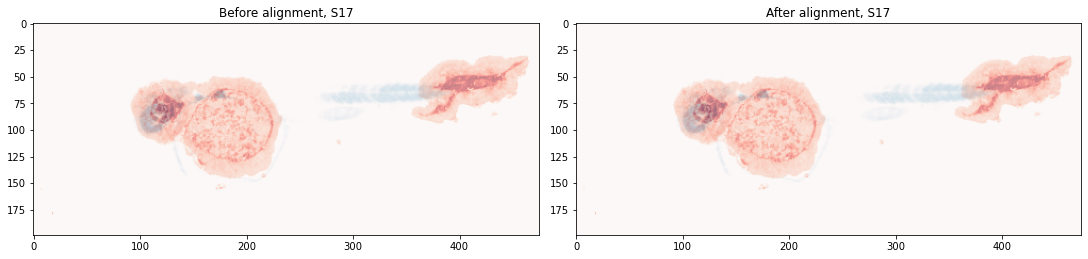

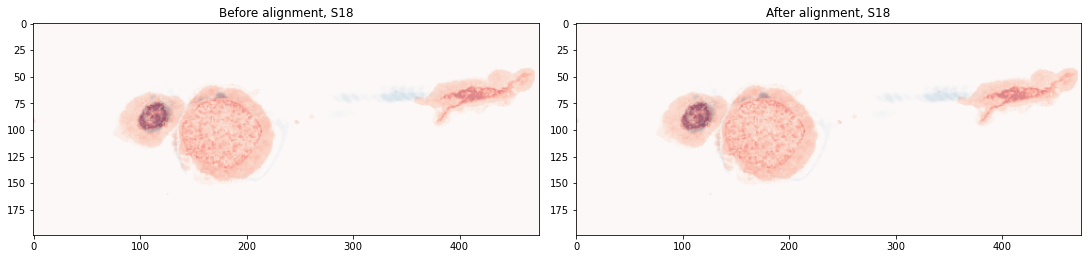

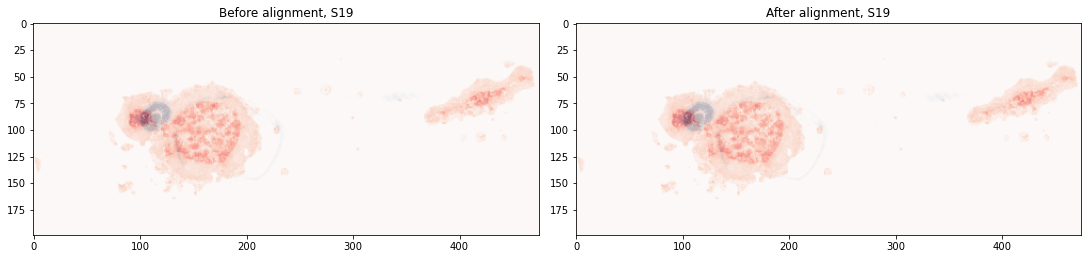

In [18]:
# Potentially ignore warping as it doesn't bring better results
ignore_warping = True

# Empty list to store the registered images
l_result_images = []

# Browse each pair of slices that must be warped with each other and do the warping
for idx, (image_ref, image_data) in enumerate(zip(array_images_reference, array_images_data)):

    # Convert the images to gray level if needed
    if image_data.shape[2] == 3:
        moving_image = rgb2gray(image_data)
    else:
        moving_image = np.squeeze(image_data)
    fixed_image = image_ref

    # Convert images to float32 as it's the only supported type by itk
    fixed_image = np.array(fixed_image, dtype=np.float32)
    moving_image = np.array(moving_image, dtype=np.float32)

    if not ignore_warping:
        logging.info(
            "Warping will start now. Please be aware that the pipeline for data warping doesn't"
            " take into account deformation field yet. To get a final visualization, you need to"
            " ignore warping."
        )

        # Set registration parameters using itk-elastix
        parameter_object = itk.ParameterObject.New()

        # Translation transform
        parameter_map_rigid = parameter_object.GetDefaultParameterMap("translation", 4)
        parameter_object.AddParameterMap(parameter_map_rigid)

        # Affine transform
        parameter_map_affine = parameter_object.GetDefaultParameterMap("affine", 3)
        parameter_object.AddParameterMap(parameter_map_affine)

        # Call registration function
        result_image, result_transform_parameters = itk.elastix_registration_method(
            fixed_image, moving_image, parameter_object=parameter_object, log_to_console=False
        )

    # Cast result images to numpy arrays
    fixed_image_np = np.asarray(fixed_image).astype(np.float32)
    moving_image_np = np.asarray(moving_image).astype(np.float32)
    result_image_np = np.copy(moving_image_np)  # np.asarray(result_image).astype(np.float32)

    # Remove negative values coming from registration
    result_image_np = np.clip(result_image_np, 0, None)

    # Store resulting image in l_result_images
    l_result_images.append(result_image_np)

    # Compare before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), constrained_layout=True)

    # Plot the comparison before and after alignement
    ax1.imshow(fixed_image_np, alpha=0.5, cmap="Blues")
    ax1.imshow(moving_image_np, alpha=0.5, cmap="Reds")
    ax1.set_title("Before alignment, S" + str(idx))
    ax2.imshow(fixed_image_np, alpha=0.5, cmap="Blues")
    ax2.imshow(result_image_np, alpha=0.5, cmap="Reds")
    ax2.set_title("After alignment, S" + str(idx))
    plt.show()

# Convert the list of resulting images in a numpy array
array_result_images = np.array(l_result_images)


### Prepare data for 3D reconstruction

In [19]:
# Decrease dimensionality for plotting, remaning isotropic with respect to previous decrease
decrease_dimensionality_factor = 6  # subsampling was 3

# Subsample reference array
array_reference_sub = array_tilted[
    ::decrease_dimensionality_factor,
    ::decrease_dimensionality_factor,
    ::decrease_dimensionality_factor,
]

# Subsample registered images array
array_result_images_sub = array_result_images[
    ::, ::decrease_dimensionality_factor, ::decrease_dimensionality_factor
]


print(array_reference_sub.shape)


(22, 34, 80)


In [20]:
# Build a 3D meshgrid to plot reference
X, Y, Z = np.mgrid[
    0 : array_reference_sub.shape[0] : array_reference_sub.shape[0] * 1j,
    0 : array_reference_sub.shape[1] : array_reference_sub.shape[1] * 1j,
    0 : array_reference_sub.shape[2] : array_reference_sub.shape[2] * 1j,
]

# Compute reference in 3D
# Coordinates are mixed up here as slices can only be displayed on z axis... No choice
volume_reference = go.Volume(
    x=Z.flatten(),
    y=Y.flatten(),
    z=X.flatten(),
    value=array_reference_sub.flatten(),
    isomin=0.04,
    isomax=1,
    opacityscale="uniform",
    surface_count=10,  # needs to be a large number for good volume rendering
)


In [21]:
# If True, plot the reference with all the slices aligned (heavy plot, quite crowded)
plot_all_slices_at_once = False
if plot_all_slices_at_once:

    # Store the plotly figure data in l_surf
    l_surf = [volume_reference]

    # Compute dimensions of the slice
    r, c = array_result_images_sub.shape[1:]

    # Compute the individual slices plot (each on the z-axis)
    for idx, idx_slice in enumerate(list_slice_idx):
        surf = go.Surface(
            z=(idx_slice + slider_shift.value + dic_individual_shifts[idx])
            * np.ones((r, c))
            / decrease_dimensionality_factor,
            surfacecolor=array_result_images_sub[idx],
            cmin=0.0,
            cmax=1,
            colorscale="viridis",
            opacityscale=[[0, 0], [0.1, 1], [1, 1]],
            showscale=False,
        )

        # Append the individual slice plot to l_surf
        l_surf.append(surf)

    # Build final figure from l_surf
    fig = go.Figure(data=l_surf)

    # No display of tick labels as they're wrong anyway
    fig.update_layout(
        scene=dict(
            xaxis=dict(showticklabels=False),
            yaxis=dict(showticklabels=False),
            zaxis=dict(showticklabels=False),
        )
    )

    # Show plot
    fig.show()


In [22]:
if False:
    # Choose value for initial slice to display
    initial_slice = 1

    # Slider to display invidual slices on the reference 3D object
    slice_index_slider = widgets.IntSlider(
        min=1,
        max=array_result_images_sub.shape[0],
        step=1,
        value=initial_slice,
        description="Slice index",
        continuous_update=False,
    )

    # Compute dimensions of the slice
    r, c = array_result_images_sub.shape[1:]

    # Assign an empty figure widget with two traces: one for the reference object,
    # the other for the current slice
    idx = 10- 1
    idx_slice = list_slice_idx[idx]

    # Compute slice plot in 3D
    surf = go.Surface(
        z=(idx_slice + slider_shift.value + dic_individual_shifts[idx])
        * np.ones((r, c))
        / decrease_dimensionality_factor,
        surfacecolor=array_result_images_sub[idx],#.astype(np.float32),
        cmin=0.0,
        cmax=1,
        colorscale="viridis",
        opacityscale=[[0, 0], [0.1, 1], [1, 1]],
        showscale=False,
    )

    # Build final figure
    g = go.FigureWidget(data=[volume_reference, surf])

    # Function to update plot when slider value changes
    def response(change):
        # Compute new slice index
        idx = slice_index_slider.value - 1
        idx_slice = list_slice_idx[idx]
        with g.batch_update():
            # Update both slice position and surface value according to new index
            g.data[1].surfacecolor[:] = array_result_images_sub[idx][:]
            g.data[1].z = (
                (idx_slice + slider_shift.value + dic_individual_shifts[idx])
                * np.ones((r, c))
                / decrease_dimensionality_factor
            )
            


    # Link slider to plot
    slice_index_slider.observe(response, names="value")

    # Display final result
    widgets.VBox([slice_index_slider, g])



In [23]:
# Get a 3D object by interpolating the slices

def return_interpolated_array(array_lipids):
    # First get an empty array of the same shape as the reference
    array_maldi_interp = np.zeros(array_tilted.shape)

    # Then fill the slices where they should be filled
    x = []
    for idx in range(array_lipids.shape[0]):
        idx_slice = list_slice_idx[idx]
        array_maldi_interp[idx_slice + slider_shift.value + dic_individual_shifts[idx],:,:] = array_lipids[idx]
        x.append(idx_slice + slider_shift.value + dic_individual_shifts[idx])

    # Compute the function for interpolation
    x = np.array(x)
    y = np.linspace(0,array_maldi_interp.shape[1], array_maldi_interp.shape[1]) 
    z = np.linspace(0,array_maldi_interp.shape[2], array_maldi_interp.shape[2]) 
    fn = RegularGridInterpolator((x,y,z), array_lipids, method = 'linear', bounds_error = False, fill_value = 0)

    # Function to compute the points that will have to be interpolated
    @njit
    def compute_list_of_points_to_interpolate(array_maldi_interp):
        l_to_interpolate = []
        for i in range(array_maldi_interp.shape[0]):
            for j in range(array_maldi_interp.shape[1]):
                for k in range(array_maldi_interp.shape[2]):
                    if array_maldi_interp[i,j,k] == 0:
                        l_to_interpolate.append([i,j,k])
        return np.array(l_to_interpolate, dtype = np.int64)

    # Function to fill the empty space with the interpolated points
    @njit
    def fill_list_of_points_interpolated(array_maldi_interp, pts, pts_interp):
        for idx, pt in enumerate(pts):
            i,j,k = pt
            array_maldi_interp[i,j,k] = pts_interp[idx]
        return array_maldi_interp

    # Compute the points that will have to be interpolated
    pts = compute_list_of_points_to_interpolate(array_maldi_interp)

    # Interpolate the points
    pts_interp = fn(pts)

    # Fill the empty space with the interpolated points
    array_maldi_interp = fill_list_of_points_interpolated(array_maldi_interp, pts, pts_interp)

    return array_maldi_interp

if False:
    multiprocessing = True
    # Do the interpolation with the dataset used for registration
    array_maldi_interp = return_interpolated_array(array_result_images)

    # Do the interpolation with all lipids
    l_lipids = list(dic_lipid_arrays.keys())

    if multiprocessing:
        with Pool(processes=24) as pool:
            l_arrays = [x for x in pool.map(return_interpolated_array, [dic_lipid_arrays[lipid] for lipid in l_lipids])]
            dic_lipid_arrays = {lipid: array for lipid, array in zip(l_lipids, l_arrays)}
    else:
        for lipid in l_lipids:
            dic_lipid_arrays[lipid] = return_interpolated_array(dic_lipid_arrays[lipid])
        
    # Pickle result as it's quite heavy
    with open('temp/interp.pickle', 'wb') as handle:
        pickle.dump([array_maldi_interp, dic_lipid_arrays], handle)

In [24]:
if True:
    # Load result
    with open('temp/interp.pickle', 'rb') as handle:
        [array_maldi_interp, dic_lipid_arrays] = pickle.load(handle)
    l_lipids = list(dic_lipid_arrays.keys())

In [25]:
# Subsample for display
decrease_dimensionality_factor = 3

# Subsample reference array
array_ref_interp_sub = array_tilted[
    ::decrease_dimensionality_factor,
    ::decrease_dimensionality_factor,
    ::decrease_dimensionality_factor,
]

# Subsample interpolated maldi array
array_maldi_interp_sub = array_maldi_interp[
    ::decrease_dimensionality_factor,
    ::decrease_dimensionality_factor,
    ::decrease_dimensionality_factor,
]

# Subsample dic of all lipids
dic_lipid_arrays_sub = copy.copy(dic_lipid_arrays)
for lipid in l_lipids:
    dic_lipid_arrays_sub[lipid] = dic_lipid_arrays[lipid][
        ::decrease_dimensionality_factor,
        ::decrease_dimensionality_factor,
        ::decrease_dimensionality_factor,
    ]
    
# Renormalize everything for nicer plotting
for lipid in l_lipids:
    dic_lipid_arrays_sub[lipid] /= np.percentile(dic_lipid_arrays_sub[lipid], 99.99)

# Build a 3D meshgrid to plot 
X, Y, Z = np.mgrid[
    0 : array_ref_interp_sub.shape[0] : array_ref_interp_sub.shape[0] * 1j,
    0 : array_ref_interp_sub.shape[1] : array_ref_interp_sub.shape[1] * 1j,
    0 : array_ref_interp_sub.shape[2] : array_ref_interp_sub.shape[2] * 1j,
]

In [26]:
if False:
    # Compute maldi in 3D
    volume_maldi = go.Volume(
        x=X.flatten(),
        y=Z.flatten(),
        z=-Y.flatten(),
        value=array_maldi_interp_sub.flatten(),
        isomin=0.02,
        isomax=0.9,
        opacityscale="uniform",
        surface_count=10,  # needs to be a large number for good volume rendering
        colorscale="viridis",
    )

    shape_ref_flat = len(array_ref_interp_sub)
    # Compute reference in 3D
    volume_reference = go.Volume(
        x=X.flatten(),
        y=Z.flatten(),
        z=-Y.flatten(),
        value=np.zeros((shape_ref_flat,)),
        isomin=0.01,
        isomax=1,
        opacity = 0.1,
        opacityscale="uniform",
        surface_count=10,  # needs to be a large number for good volume rendering
    )


    # dropdown to display invidual lipids
    lipid_dropdown = widgets.Dropdown(
        value=l_lipids[0],
        options=l_lipids + ['alignment data'],
        description="Lipid to display:",
    )

    # Tickbox to superimpose reference
    superimpose_reference = widgets.Checkbox(description="Superimpose reference", value=False)



    # Build final figure
    g = go.FigureWidget(data=[volume_maldi, volume_reference])
    # No display of colormap 
    g.update_traces(showscale=False)
    # No display of tick labels as they're wrong anyway
    g.update_layout(scene=dict(
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(showticklabels=False),
        ))


    # Function to update plot when slider value changes
    def response(change):


        with g.batch_update():
            if lipid_dropdown.value=='alignment data':
                val = array_maldi_interp_sub.flatten()
            else:
                val = dic_lipid_arrays_sub[lipid_dropdown.value].flatten()
            # Update volume
            g.data[0].value = val
            
            # Potentially superimpose reference
            if superimpose_reference.value:
                g.data[1].value = array_ref_interp_sub.flatten()
            else:
                g.data[1].value = np.zeros((shape_ref_flat,))
            


    # Link widgets to plot
    lipid_dropdown.observe(response, names="value")
    superimpose_reference.observe(response, names="value")

    # Gather widgets in container
    container = widgets.HBox(children=[lipid_dropdown, superimpose_reference])


    # Display final result
    widgets.VBox([container, g])

### Cluster samples to know which patters are in the data

In [27]:
# Turn the individual arrays of expression into an array of features
l_lipids = list(dic_lipid_arrays_sub.keys())
array_lipid_exp = np.array([dic_lipid_arrays_sub[key].flatten() for key in l_lipids])

In [28]:
# Compute a UMAP projection and do clustering on the result
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(array_lipid_exp)
kmeans = KMeans(n_clusters=3, random_state=0).fit(proj_2d)

In [29]:
# Plot the result
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=[str(x) for x in kmeans.labels_],
    text = [str(i) + '\n\n' + x for i, x in enumerate(l_lipids)], size_max=6
)
fig_2d.update_traces(textposition='top center', textfont_size=8)

fig_2d.show()

### Plot and animate the most interesting lipids in 3D

In [30]:
array_lipid_mz = np.array(l_lipids, dtype = float)

# Find the indices of the lipids to plot
mz_1 = 785.587
index_1, = np.isclose(array_lipid_mz, mz_1).nonzero()
lipid_1 = l_lipids[index_1[0]]

mz_2 = 518.322
index_2, = np.isclose(array_lipid_mz, mz_2).nonzero()
lipid_2 = l_lipids[index_2[0]]

mz_3 = 658.150
index_3, = np.isclose(array_lipid_mz, mz_3).nonzero()
lipid_3 = l_lipids[index_3[0]]

print(index_1, lipid_1)
print(index_2, lipid_2)
print(index_3, lipid_3)

[92] 785.587916
[8] 518.322183
[49] 658.150162


In [31]:
if True:

    # Initial coordinates
    x_eye=1.25*1.2
    y_eye=0.1*1.2
    z_eye=1.25*1.2

    # Function for 3D rotation
    def rotate_y(x, y, z, theta):
        w = x+1j*z
        return np.real(np.exp(1j*theta)*w), y, np.imag(np.exp(1j*theta)*w)

    # Compute first maldi lipid in 3D
    volume_maldi = go.Volume(
        x=X.flatten(),
        y=Z.flatten(),
        z=-Y.flatten(),
        value=dic_lipid_arrays_sub[lipid_1].flatten(),
        isomin=0.02,
        isomax=1.,
        opacity = 0.,
        opacityscale="uniform",
        surface_count=10,  # needs to be a large number for good volume rendering
        colorscale="Reds",
    )

    # Compute second maldi lipid in 3D
    volume_maldi_2 = go.Volume(
        x=X.flatten(),
        y=Z.flatten(),
        z=-Y.flatten(),
        value=dic_lipid_arrays_sub[lipid_2].flatten(),
        isomin=0.02,
        isomax=1.,
        opacity = 0.,
        opacityscale="uniform",
        surface_count=10,  # needs to be a large number for good volume rendering
        colorscale="Greens",
    )

    # Compute third maldi lipid in 3D
    volume_maldi_3 = go.Volume(
        x=X.flatten(),
        y=Z.flatten(),
        z=-Y.flatten(),
        value=dic_lipid_arrays_sub[lipid_3].flatten(),
        isomin=0.02,
        isomax=1.,
        opacity = 0.,
        opacityscale="uniform",
        surface_count=10,  # needs to be a large number for good volume rendering
        colorscale="Blues",
    )

    # Compute reference in 3D
    shape_ref_flat = len(array_ref_interp_sub)
    volume_reference = go.Volume(
        x=X.flatten(),
        y=Z.flatten(),
        z=-Y.flatten(),
        value=array_ref_interp_sub.flatten(),
        isomin=0.04,
        isomax=1,
        opacity = 0.,
        opacityscale="uniform",
        surface_count=10,  # needs to be a large number for good volume rendering
        colorscale="YlOrBr",
    )

    # Define figure and layout
    fig = go.Figure(data=[volume_reference, volume_maldi, volume_maldi_2, volume_maldi_3])

    # Transparent background
    fig.update_layout(
        margin=dict(t=0, r=0, b=0, l=0),
        scene=dict(
            xaxis=dict(backgroundcolor="rgba(0,0,0,0)",color="white", gridcolor="white", showticklabels=False),
            yaxis=dict(backgroundcolor="rgba(0,0,0,0)",color="white", gridcolor="white", showticklabels=False),
            zaxis=dict(backgroundcolor="rgba(0,0,0,0)",color="white", gridcolor="white", showticklabels=False),
        ),
        # Bigger size for nicer display
        width=1000,
        height=600,
    )
    fig.update_layout(
        title={
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'}
    )

    # No colorbar
    fig.update_traces(showscale=False)

    # Update with rotation
    time_domain = np.arange(0, 510, 1)
    l_fig = []
    for image, t in enumerate(time_domain):
        fig_rotated = copy.deepcopy(fig)

        # Only reference
        if t<100:
            # Title
            fig_rotated.update_layout(title_text='Reference')
            # Set reference
            fig_rotated.data[0].opacity = 1 
            # set data to 0
            fig_rotated.data[1].opacity = 0
            fig_rotated.data[2].opacity = 0
            fig_rotated.data[3].opacity = 0
            

        elif t>=100 and t<150:
            # No more title as switch taking place
            fig_rotated.update_layout(title_text='')
            # Progressively remove reference
            fig_rotated.data[0].opacity = (150-t)/50
            # Progressively show first lipid
            fig_rotated.data[1].opacity = (t-100)/50

        # Remove reference always after t=150, and display data always
        elif t>=150 and t<250:
            # Title
            fig_rotated.update_layout(title_text='mz = ' +lipid_1)
            # First lipid is displayed fully
            fig_rotated.data[1].opacity = 1

        # Switch between two lipids
        elif t>=250 and t<280:
            # No more title as switch taking place
            fig_rotated.update_layout(title_text='')

            # Fade away lipid 1
            fig_rotated.data[1].opacity = (280-t)/30
            # Progressivelu show lipid 2
            fig_rotated.data[2].opacity = (t-250)/30

        # Just leave lipid 2
        elif t>=280 and t<380:
            # Title
            fig_rotated.update_layout(title_text='mz = ' +lipid_2)
            # Lipid 2 is displayed fully
            fig_rotated.data[2].opacity = 1

        # Progressively display lipid 3
        elif t>=380 and t<410:
            # No more title as switch taking place
            fig_rotated.update_layout(title_text='')
            # Lipid 2 fades away
            fig_rotated.data[2].opacity = (410-t)/30
            # Lipid 3 appears
            fig_rotated.data[3].opacity = (t-380)/30

        # Just leave new lipid
        elif t>=410 and t<510:
            # Title
            fig_rotated.update_layout(title_text='mz = ' +lipid_3)

            # Lipid 3 is displayed fully
            fig_rotated.data[3].opacity = 1
        
        # # Progressively show all lipids
        # elif t>=510 and t<540:
        #     # No more title as switch taking place
        #     fig_rotated.update_layout(title_text='')
        #     # Lipid 3 fades away
        #     fig_rotated.data[3].opacity = (540-t)/30 + (t-510)/30*0.3
        #     # Lipid 1 appears
        #     fig_rotated.data[1].opacity = (t-510)/30*0.3
        #     # Lipid 2 appears
        #     fig_rotated.data[2].opacity = (t-510)/30*0.3

        # # Show all lipids
        # elif t>=540:
        #     # Title
        #     fig_rotated.update_layout(title_text='Three lipids together')
        #     # All lipids displayed
        #     fig_rotated.data[1].opacity = 0.3
        #     fig_rotated.data[2].opacity = 0.3
        #     fig_rotated.data[3].opacity = 0.3                

        # Rotate camera
        xe, ye, ze = rotate_y(x_eye, y_eye, z_eye, -t/40)
        camera = dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=xe, y=ze, z=ye),
        )
        fig_rotated.update_layout(scene_camera=camera)

        # Append final figure to the list of images
        l_fig.append((image,fig_rotated))



In [ ]:
# Compute individual images for 3D lipid animation
if True:
    multiprocessing = True

    def write_figure(t_fig):
        image,fig = t_fig
        fig.write_image("output/fig" + format(image,'04d')+".png")
        
    if multiprocessing:
        with Pool(processes=4) as pool:
            [x for x in pool.map(write_figure, l_fig)]
            
    else:
        for image,fig in l_fig:
            print("Plotting figure " + str(image))
            fig.write_image("output/fig" + format(image,'04d')+".png")
            #break

In [ ]:
if True:
    # Merge images into a gif
    i = "output/*.png"
    o = "output/output.gif"
    subprocess.call("convert -delay 3 -loop 0 " + i + " " + o, shell=True)
